# AIプログラムを構築してみよう
土木学会学会誌２０２１年1月号
サンプルコードと解説
テーマ：
「さあ，ＡＩを始めよう」
～土木工学へのAI導入のススメ～
AI入門講座（2）
～AIプログラムを構築してみよう～
埼玉大学　党紀


# （０）説明
AIプログラムを構築するための知識を説明するために、一例として、畳み込みニューラルネットワークCNNで、画像分類問題を説明していきたいと思います。

使用モデル:CNN, ResNet

学習用データ:腐食とひび割れ分類

おおむね3つの部分で構成します：（１）準備、（２）訓練、（３）予測



#（１）準備
まずは環境設定、疑似環境を作る必要がないのですが：



1.   「ランタイム」メニュから「ランタイムのタイプを変更」を選択し、ハードウェアアクセラレーターをGPUと選択。最後に「保存」を押してください。
2.   グーグルドライブとつなぐ（マウント）下記のセールのコードを実施し，あらわされたリンクをクリックして、グーグルアカウントでログインしてください。その後現れたコードをコーヒーして、このページに戻り、下の空欄に貼り付けて「Enter」キーを押して実施。
2.　下記のセールの後半では，作業フォルダを設定します。このファイルもグーグルドライブのColab Notebooks/CNNというフォルダに置いてください。   





In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls
import os
os.chdir('./drive/My Drive/Colab Notebooks/CNN/')

Mounted at /content/drive
drive  sample_data


##手持ちデータV.Sデモ用データ
###マイデータを使う
訓練用データをグーグルドライブの工作用フォルダにいれてください。
Picsというフォルダにいれてください。
###デモしてみる
デモのためにここではダウンロードコードを書いております、下記のセールを実施することで自動的にデータがダウンロードされる。
自分のPCでJupyter Notebookで本ファイルを実施する場合下記のリンクからダウンロードしてください。
https://drive.google.com/file/d/1m6SPFcX01OKAENjltBOfDY9sGm3RhjSV/view?usp=sharing


In [ ]:
from google_drive_downloader import GoogleDriveDownloader
#https://drive.google.com/file/d/1m6SPFcX01OKAENjltBOfDY9sGm3RhjSV/view?usp=sharing
#https://drive.google.com/file/d/1JqtYRBbJGw0EniZJgAtTCwIhm6fKpT3k/view?usp=sharing
GoogleDriveDownloader.download_file_from_google_drive(file_id='1JqtYRBbJGw0EniZJgAtTCwIhm6fKpT3k',
                                                      dest_path="./data.zip",
                                                      unzip=True)
!rm data.zip        
!ls

Unzipping...Done.
Achieves     confutionmatrix.jpg  mnist_mlp_model.json	Pics
cnn02.ipynb  data		  mnist_mlp_weights.h5	steel
cnn03.ipynb  elephant.jpg	  model.png		val_acc.jpg
cnn.ipynb    __MACOSX		  mymodel_weights.h5


＃ライブラリの導入

In [ ]:
# some libraries
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation, Conv2D, Flatten, Dense,Dropout
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, Adamax, RMSprop, Nadam
from keras.utils import plot_model
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
import time
import os

フォルダの設定です、マイデータの場合ほかのフォルダ名にしてください、デモの場合そのまま実施してください。

In [ ]:
## some constant
foldername="data"

データの情報を確認します。“data”の中に腐食分類問題として、「A」,「B」,「C」３ランクの写真がそれぞれ「A」,「B」,「C」のフォルダに収納しています。

フォルダ名をそれぞれクラス名として使われます。



In [ ]:
def listdir_nohidden(path): #macでは.ds_dataなど見えないフォルダが存在するので、ここで除去
    filelist=[]
    for f in os.listdir(path):
        if not f.startswith('.'):
            filelist.append(f)
    return filelist

folder = listdir_nohidden(foldername)
folder=sorted(folder)
name_classes=folder
num_classes=len(folder)
image_size = 224
dense_size  = len(name_classes)
print(folder)

['A', 'B', 'C']


##データの導入とをデータの可視化
**データを読み込んで、それぞれ訓練用とテスト用に分けます。**

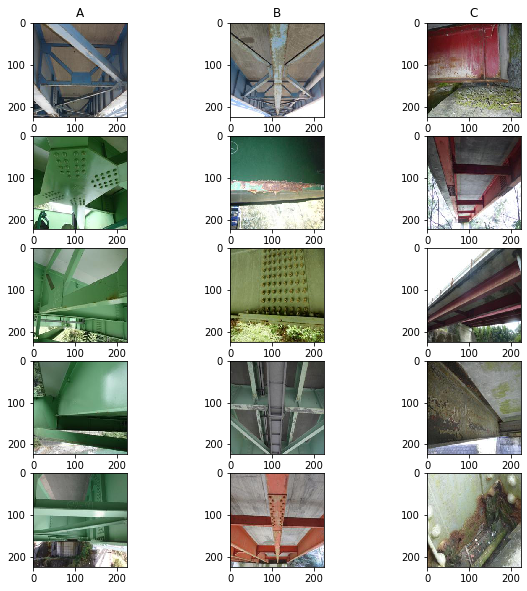

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
X = []
Y = []
samples_per_class=5
for index, classname in enumerate(folder): #enumerate番号と配列を同時取得
    dir = "./"+foldername+"/" + classname
    files = glob.glob(dir + "/*.jpg")
    pickedfiles = np.random.choice(files, samples_per_class, replace=False)
    pickedfiles=sorted(pickedfiles)
    #print(classname,pickedfiles)
    iclass=0
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        X.append(data)
        Y.append(index)
        if file in pickedfiles:
            plt_idx = iclass * num_classes + index + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            if iclass == 0:
                plt.title(classname)
            plt.imshow(data)
            iclass+=1
    

X = np.array(X)
Y = np.array(Y)
X = X.astype('float32')
X = X / 255.0

Y = np_utils.to_categorical(Y, dense_size)#kerasの小道具箱np_utilsを活用
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10) #sklearnを活用

# （２）訓練
これで下準備は完了ですので、訓練の段階に入ります。

まずはモデルを構築します。このデモではkerasを使います。既存のモデルならvgg16などは直接引用することもできます。一行で済みますね。

model=keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

ここでは中身を示すために０から構築していきます。

ほかのデモはkerasのhpからも解説などがあります。

https://keras.io/ja/applications/


## Resnetを使ってみる

###モデルを導入する

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
model = ResNet50(weights='imagenet')


###モデルを使ってみる

Unzipping...Done.


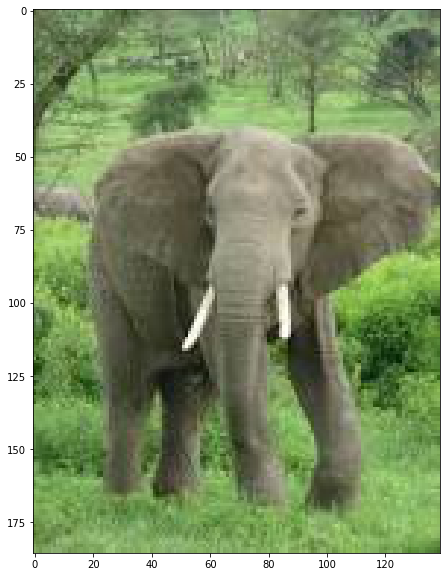

Predicted: [('n02504458', 'African_elephant', 0.5790134), ('n01871265', 'tusker', 0.33651444), ('n02504013', 'Indian_elephant', 0.084472135)]


In [ ]:
#何かの写真ダウンロードしておく
#例えば象の写真
#https://drive.google.com/file/d/1sLApKnnYWTzil24jJt2KuKJbb3DSQ1dd/view?usp=sharing
from google_drive_downloader import GoogleDriveDownloader
GoogleDriveDownloader.download_file_from_google_drive(file_id='1Vb989Nq0sgi7RI7CUXiSzr1KIcbLZ7k7',
                                                      dest_path="./e.zip",
                                                      unzip=True)
!rm e.zip

def predict_one(img_path = 'elephant.jpg'):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.show()
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    print('Predicted:', decode_predictions(preds, top=3)[0])
    # Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]
predict_one(img_path = 'elephant.jpg')


## 移転学習してみる

### モデル構成
まずは、既存モデルをベースにしてNN部分だけ作る

In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 3 classes
predictions = Dense(num_classes, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


94773248/94765736 [==============================] - 2s 0us/step


###移転学習の訓練


訓練結果可視化ための関数
+訓練

Epoch 1/100
20/20 [==============================] - 6s 316ms/step - loss: 1.9964 - accuracy: 0.3594 - val_loss: 1.2296 - val_accuracy: 0.3857
Epoch 2/100
20/20 [==============================] - 4s 211ms/step - loss: 1.3802 - accuracy: 0.3546 - val_loss: 1.5866 - val_accuracy: 0.3143
Epoch 3/100
20/20 [==============================] - 4s 212ms/step - loss: 1.3252 - accuracy: 0.3562 - val_loss: 1.1534 - val_accuracy: 0.3857
Epoch 4/100
20/20 [==============================] - 4s 212ms/step - loss: 1.2864 - accuracy: 0.3419 - val_loss: 1.2623 - val_accuracy: 0.3571
Epoch 5/100
20/20 [==============================] - 4s 213ms/step - loss: 1.2446 - accuracy: 0.3275 - val_loss: 1.1892 - val_accuracy: 0.3571
Epoch 6/100
20/20 [==============================] - 4s 213ms/step - loss: 1.1903 - accuracy: 0.3802 - val_loss: 1.0621 - val_accuracy: 0.3571
Epoch 7/100
20/20 [==============================] - 4s 213ms/step - loss: 1.2102 - accuracy: 0.3514 - val_loss: 1.1571 - val_accuracy: 0.2857

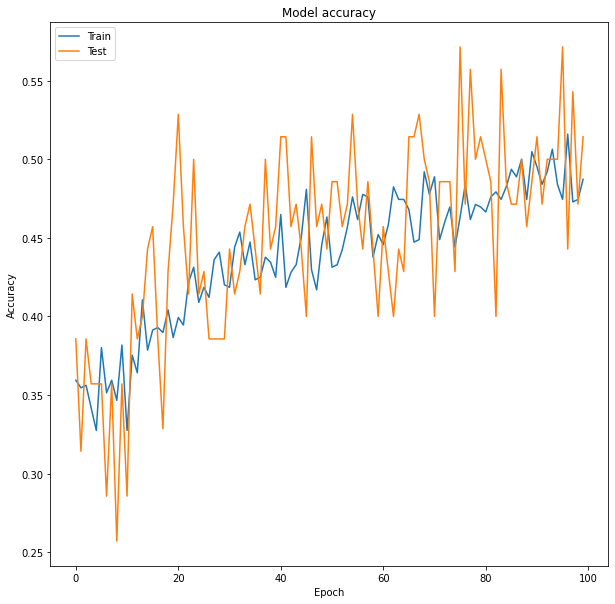

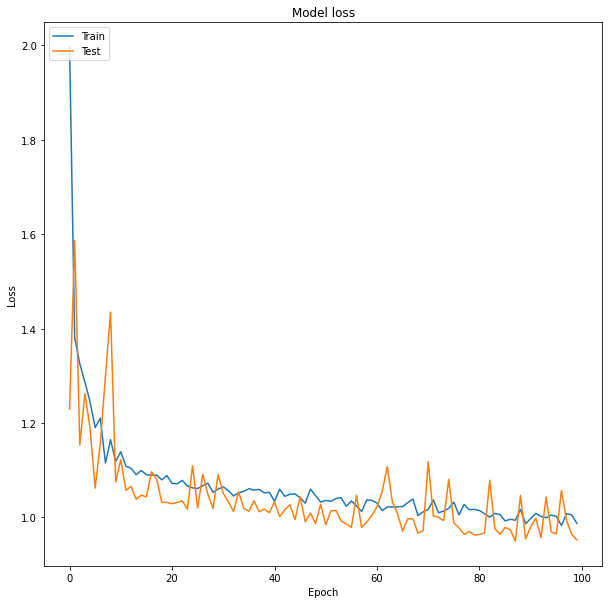

In [ ]:
def visualizeHistory(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    return None

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=["accuracy"])
epochs = 300  # 300?
# train the model on the new data for a few epochs
history=model.fit(X_train, y_train, validation_split=0.1, epochs=epochs)
visualizeHistory(history)


model.save_weights('mymodel_weights.h5')

### 仕上げしてあげようFune Tuning


In [ ]:
plot_model(model, to_file='model.png')
for i,layer in enumerate(model.layers):
    print("layer:%d"%i,layer.name)


layer:0 input_3
layer:1 conv1_pad
layer:2 conv1_conv
layer:3 conv1_bn
layer:4 conv1_relu
layer:5 pool1_pad
layer:6 pool1_pool
layer:7 conv2_block1_1_conv
layer:8 conv2_block1_1_bn
layer:9 conv2_block1_1_relu
layer:10 conv2_block1_2_conv
layer:11 conv2_block1_2_bn
layer:12 conv2_block1_2_relu
layer:13 conv2_block1_0_conv
layer:14 conv2_block1_3_conv
layer:15 conv2_block1_0_bn
layer:16 conv2_block1_3_bn
layer:17 conv2_block1_add
layer:18 conv2_block1_out
layer:19 conv2_block2_1_conv
layer:20 conv2_block2_1_bn
layer:21 conv2_block2_1_relu
layer:22 conv2_block2_2_conv
layer:23 conv2_block2_2_bn
layer:24 conv2_block2_2_relu
layer:25 conv2_block2_3_conv
layer:26 conv2_block2_3_bn
layer:27 conv2_block2_add
layer:28 conv2_block2_out
layer:29 conv2_block3_1_conv
layer:30 conv2_block3_1_bn
layer:31 conv2_block3_1_relu
layer:32 conv2_block3_2_conv
layer:33 conv2_block3_2_bn
layer:34 conv2_block3_2_relu
layer:35 conv2_block3_3_conv
layer:36 conv2_block3_3_bn
layer:37 conv2_block3_add
layer:38 conv

層番号を見てみるとconv5まできりがいいので143何まで開放してあげよう

In [ ]:
num_free_layer=143
for layer in model.layers[:num_free_layer]:
   layer.trainable = False
for layer in model.layers[num_free_layer:]:
   layer.trainable = True


それとも大変時間がかかるからepoch数は控えめに

Epoch 1/100
20/20 [==============================] - 4s 219ms/step - loss: 0.9980 - accuracy: 0.4904 - val_loss: 0.9803 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 4s 214ms/step - loss: 0.9955 - accuracy: 0.4904 - val_loss: 1.2680 - val_accuracy: 0.3714
Epoch 3/100
20/20 [==============================] - 4s 212ms/step - loss: 1.0049 - accuracy: 0.4872 - val_loss: 0.9583 - val_accuracy: 0.5143
Epoch 4/100
20/20 [==============================] - 4s 211ms/step - loss: 0.9793 - accuracy: 0.4984 - val_loss: 0.9553 - val_accuracy: 0.4714
Epoch 5/100
20/20 [==============================] - 4s 211ms/step - loss: 0.9862 - accuracy: 0.4776 - val_loss: 0.9772 - val_accuracy: 0.5000
Epoch 6/100
20/20 [==============================] - 4s 213ms/step - loss: 0.9993 - accuracy: 0.4936 - val_loss: 0.9705 - val_accuracy: 0.5143
Epoch 7/100
20/20 [==============================] - 4s 213ms/step - loss: 0.9729 - accuracy: 0.5000 - val_loss: 1.1976 - val_accuracy: 0.4286

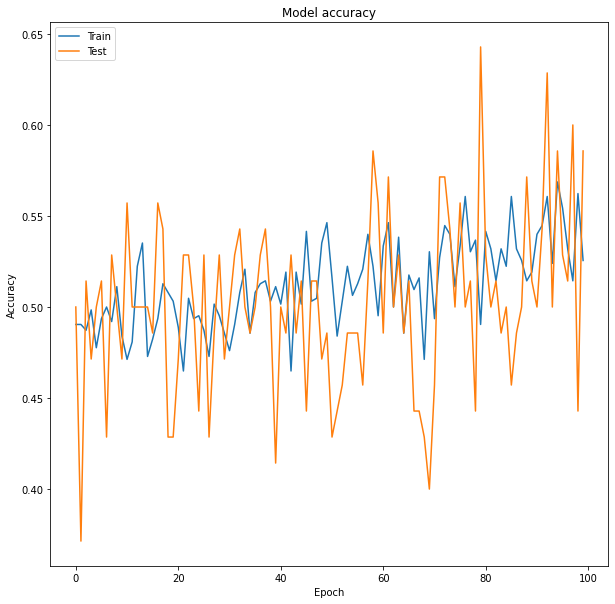

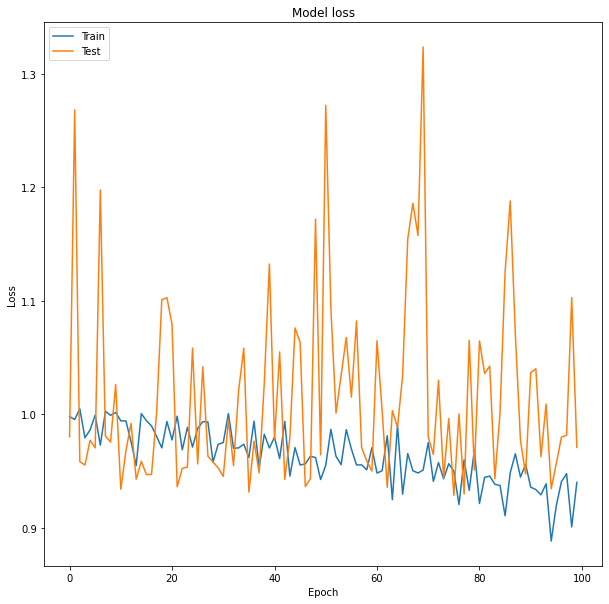

In [ ]:
epochs = 100  # 300?
# train the model on the new data for a few epochs
history=model.fit(X_train, y_train, validation_split=0.1, epochs=epochs)
visualizeHistory(history)
model.save_weights('mymodel_weights_final.h5')

### 合わせて書く

Epoch 1/300
20/20 [==============================] - 5s 268ms/step - loss: 1.9901 - accuracy: 0.3498 - val_loss: 1.2331 - val_accuracy: 0.3571
Epoch 2/300
20/20 [==============================] - 4s 213ms/step - loss: 1.3769 - accuracy: 0.3355 - val_loss: 1.1069 - val_accuracy: 0.3714
Epoch 3/300
20/20 [==============================] - 4s 211ms/step - loss: 1.2234 - accuracy: 0.3642 - val_loss: 1.2945 - val_accuracy: 0.2571
Epoch 4/300
20/20 [==============================] - 4s 214ms/step - loss: 1.2379 - accuracy: 0.3514 - val_loss: 1.1368 - val_accuracy: 0.3857
Epoch 5/300
20/20 [==============================] - 4s 212ms/step - loss: 1.2072 - accuracy: 0.3946 - val_loss: 1.2661 - val_accuracy: 0.3143
Epoch 6/300
20/20 [==============================] - 4s 214ms/step - loss: 1.1705 - accuracy: 0.3818 - val_loss: 1.0777 - val_accuracy: 0.4857
Epoch 7/300
20/20 [==============================] - 4s 214ms/step - loss: 1.1535 - accuracy: 0.3738 - val_loss: 1.1294 - val_accuracy: 0.3571

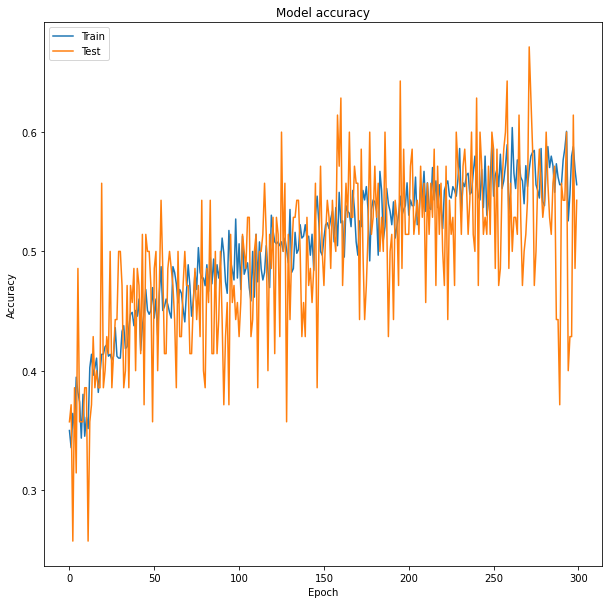

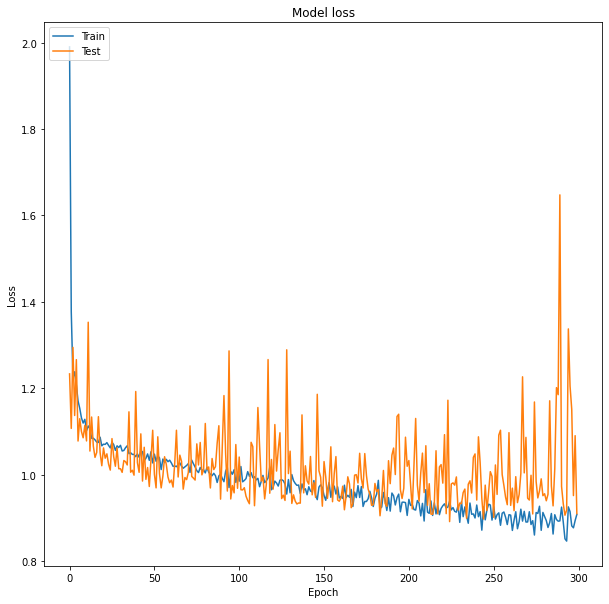

Epoch 1/100
20/20 [==============================] - 4s 216ms/step - loss: 0.8820 - accuracy: 0.5895 - val_loss: 1.2478 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 4s 214ms/step - loss: 0.9067 - accuracy: 0.5767 - val_loss: 0.9620 - val_accuracy: 0.5286
Epoch 3/100
20/20 [==============================] - 4s 214ms/step - loss: 0.9061 - accuracy: 0.5511 - val_loss: 0.9087 - val_accuracy: 0.5714
Epoch 4/100
20/20 [==============================] - 4s 213ms/step - loss: 0.8871 - accuracy: 0.5639 - val_loss: 0.9255 - val_accuracy: 0.5429
Epoch 5/100
20/20 [==============================] - 4s 216ms/step - loss: 0.8739 - accuracy: 0.5783 - val_loss: 1.0015 - val_accuracy: 0.5429
Epoch 6/100
20/20 [==============================] - 4s 216ms/step - loss: 0.9012 - accuracy: 0.5272 - val_loss: 0.9684 - val_accuracy: 0.5571
Epoch 7/100
20/20 [==============================] - 4s 215ms/step - loss: 0.8806 - accuracy: 0.5719 - val_loss: 0.9458 - val_accuracy: 0.5000

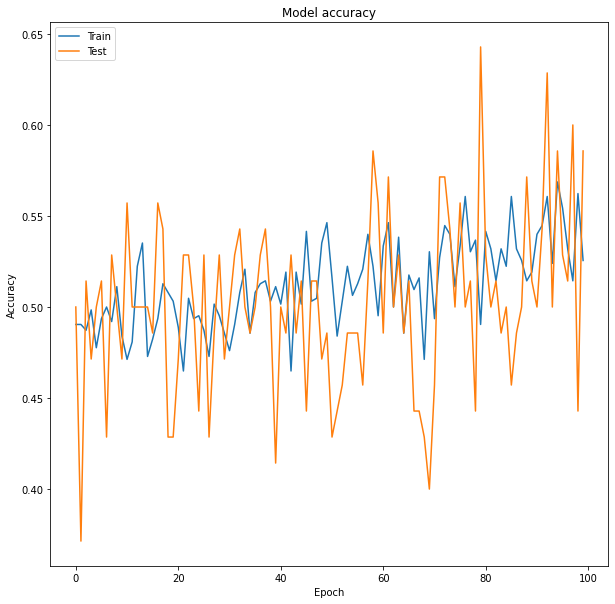

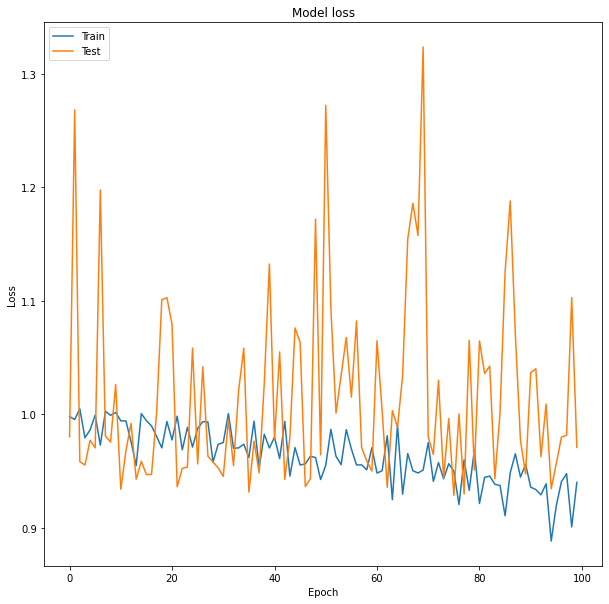

In [ ]:
#合わせて書く

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 3 classes
predictions = Dense(num_classes, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

#Stage 01
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=["accuracy"])
epochs = 300  # 300?
# train the model on the new data for a few epochs
history01=model.fit(X_train, y_train, validation_split=0.1, epochs=epochs)
visualizeHistory(history01)

#Stage 02
num_free_layer=143
for layer in model.layers[:num_free_layer]:
   layer.trainable = False
for layer in model.layers[num_free_layer:]:
   layer.trainable = True

epochs = 100  # 300?
# train the model on the new data for a few epochs
history2=model.fit(X_train, y_train, validation_split=0.1, epochs=epochs)
visualizeHistory(history)
model.save_weights('mymodel_weights_final.h5')

#（３）テストしてみる


In [ ]:

#print("num_classes:",num_classes)
samples_per_class = 3
for y, cls in enumerate(folder): #enumerate番号と配列を同時取得
    #print(y,cls)
    dir = "./"+foldername+"/" + cls
    files = glob.glob(dir + "/*.jpg")
    picedfiles = np.random.choice(files, samples_per_class, replace=False)
    for i, file in enumerate(picedfiles):
        img = image.load_img(file, target_size=(224, 224))
        plt_idx = i * num_classes + y + 1
        #print(samples_per_class,num_classes,plt_idx)
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(img)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        preds = model.predict(x)
        s="true class:"+cls+" Predicted:"+classes[preds[0].argmax()]
        #plt.title(s)
        plt.show()
        print(s)
        

NameError: ignored

## そのた：自作モデルの場合

In [ ]:
def CnnModel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(dense_size))
    model.add(Activation('softmax'))

    model.summary()
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      1

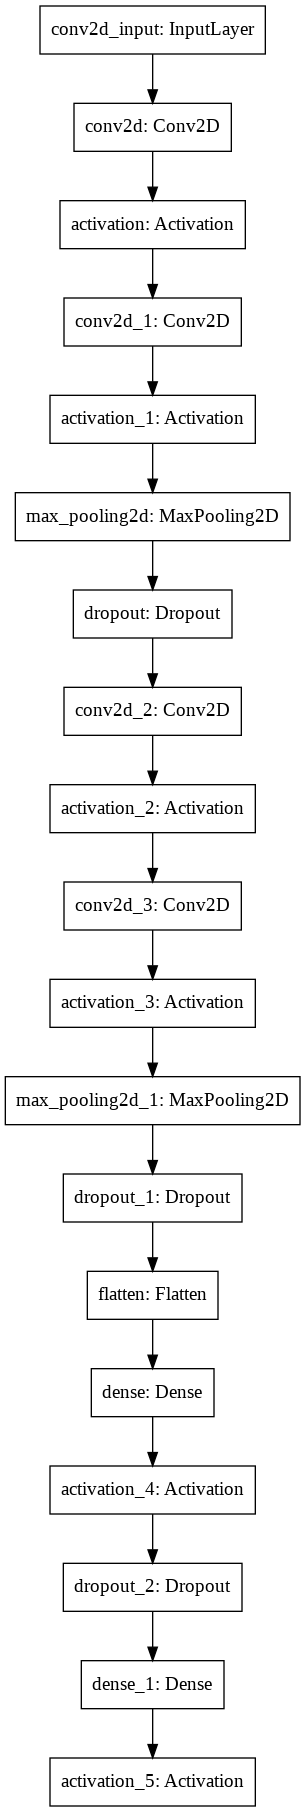

In [ ]:
model=CnnModel()

plot_model(model, to_file='model.png')


In [ ]:

#optimizers ="Adadelta"#hyperparameters:SGD, Adagrad, Adam, Adamax, RMSprop, Nadam
optimizers=Adam(lr=0.0001)
#SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
results = {}
epochs = 30     # using 100 or 200?
model.compile(loss='categorical_crossentropy', optimizer=optimizers, metrics=['accuracy'])
results= model.fit(X_train, y_train, validation_split=0.1, epochs=epochs )#<-training
model_json_str = model.to_json()
open('mnist_mlp_model.json', 'w').write(model_json_str)
model.save_weights('mymodel_weights.h5')

Epoch 1/30
20/20 [==============================] - 3s 151ms/step - loss: 1.3783 - accuracy: 0.3770 - val_loss: 1.0311 - val_accuracy: 0.5286
Epoch 2/30
20/20 [==============================] - 2s 117ms/step - loss: 1.1168 - accuracy: 0.3578 - val_loss: 1.0923 - val_accuracy: 0.4000
Epoch 3/30
20/20 [==============================] - 2s 118ms/step - loss: 1.0687 - accuracy: 0.4153 - val_loss: 1.0467 - val_accuracy: 0.5857
Epoch 4/30
20/20 [==============================] - 2s 119ms/step - loss: 1.0576 - accuracy: 0.4585 - val_loss: 1.0342 - val_accuracy: 0.5714
Epoch 5/30
20/20 [==============================] - 2s 118ms/step - loss: 1.0282 - accuracy: 0.4537 - val_loss: 0.9853 - val_accuracy: 0.6571
Epoch 6/30
20/20 [==============================] - 2s 119ms/step - loss: 0.9990 - accuracy: 0.5096 - val_loss: 0.9522 - val_accuracy: 0.5857
Epoch 7/30
20/20 [==============================] - 2s 118ms/step - loss: 0.9573 - accuracy: 0.5367 - val_loss: 0.9035 - val_accuracy: 0.6571
Epoch 

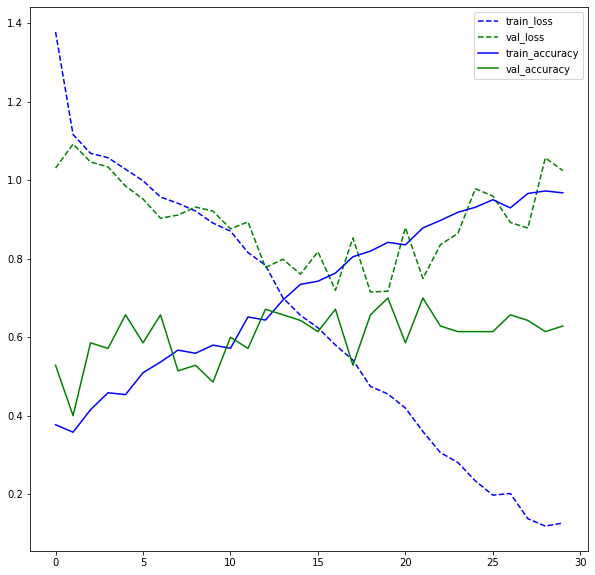

In [ ]:
# visuliazation of training

x = range(epochs)
plt.plot(x,results.history['loss'],color='blue',label='train_loss',linestyle = "dashed")
plt.plot(x,results.history['val_loss'],color='green',label='val_loss',linestyle = "dashed")
plt.plot(x,results.history['accuracy'],color='blue',label='train_accuracy')
plt.plot(x,results.history['val_accuracy'],color='green',label='val_accuracy')
plt.legend()


name = 'val_acc.jpg'
plt.savefig(name, bbox_inches='tight')


以上のように過学習してしまい、精度は上がりませんでした。

In [ ]:
#reference:https://medium.com/@manasnarkar/image-classification-with-convolution-neural-networks-cnn-with-keras-dbd71c05ed2a
test_loss, test_acc = model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 80ms/step - loss: 1.4811 - accuracy: 0.5000


In [ ]:
print(test_acc)

0.5


Confusion matrix, without normalization
[[11  4  2]
 [ 6 12  8]
 [ 7 12 16]]


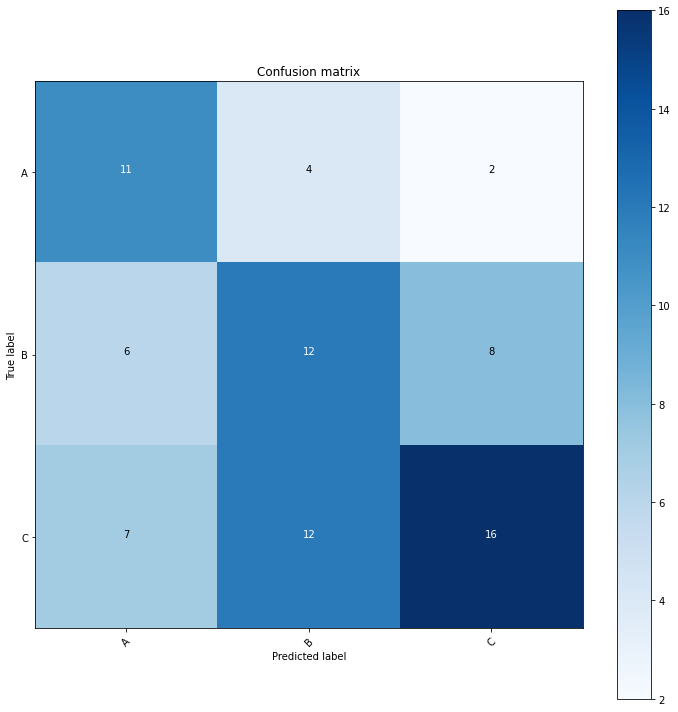

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confutionmatrix.jpg')


pred_y = model.predict(X_test)
pred_y_classes = np.argmax(pred_y,axis = 1) 
tue_y= np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(tue_y, pred_y_classes) 
plot_confusion_matrix(confusion_mtx, classes = folder) 

# reference:http://kinpatucom821.hatenablog.com/entry/2018/08/30/215419